In [3]:
import matplotlib
from matplotlib import pyplot as plt
import pandas as pd
import numpy as np
import fastprop
import os
from rdkit import Chem
import scipy
from matplotlib import cm
from matplotlib.colors import Normalize 
import seaborn as sns
from sklearn.metrics import mean_squared_error 
from pathlib import Path
from matplotlib_venn import venn2
from matplotlib_venn import venn2_circles

matplotlib.rcParams.update({'font.style': 'normal'})
matplotlib.rcParams.update({'font.sans-serif': 'Segoe UI'})
matplotlib.rcParams.update({'font.size': 26})

colors = sns.color_palette(palette='Accent').as_hex()


In [4]:
def parity_plot(xs,ys, labels, colors):
    plt.figure(figsize=[6.4,4.8])
    fig, ax1 = plt.subplots()
    ax1.plot([-6, 6], [-6,6], linestyle = '--', linewidth = 2, color = 'black')
    ax1.plot([-6, 6], [-7,5], linestyle = '--', linewidth = 2, color = 'gray', alpha = 0.4)
    ax1.plot([-6, 6], [-5,7], linestyle = '--', linewidth = 2, color = 'gray', alpha = 0.4)
    for i in range(len(xs)):
        ax1.scatter(xs[i],ys[i], alpha =0.4, s = 30, edgecolors = 'black', color = colors[i], label = labels[i])
    ax1.set_xlim([-5, 2])
    ax1.set_ylim([-5,2])
    ax1.set_ylabel(r"$\hat{logS}$")
    ax1.set_xlabel(r"True $logS$")
    ax1.legend(prop={'size': 20}, loc = 'upper left', frameon = False, bbox_to_anchor=(-0.05,1.1)) 
    ax1.spines[['right', 'top']].set_visible(False)
    return ax1

def stats(true, predicted): 
    mse = mean_squared_error(true, predicted)

    differences = np.abs(true - predicted)
    within_1_unit = differences <= 1
    percentage_within_1_unit = np.sum(within_1_unit) / len(true) * 100
    return mse, percentage_within_1_unit

def solprop_parity_plot(x,y, label, color, mse, percentage_within_1_unit):
    plt.figure(figsize=[6.4,4.8])
    fig, ax1 = plt.subplots()
    ax1.plot([-6, 6], [-6,6], linestyle = '--', linewidth = 2, color = 'black')
    ax1.plot([-6, 6], [-7,5], linestyle = '--', linewidth = 2, color = 'gray', alpha = 0.4)
    ax1.plot([-6, 6], [-5,7], linestyle = '--', linewidth = 2, color = 'gray', alpha = 0.4)
    ax1.scatter(x,y, alpha =0.4, s = 30, edgecolors = 'black', color = color, label = label)
    ax1.set_xlim([-6,3])
    ax1.set_xticks([-6, -3, 0, 3])
    ax1.set_ylim([-6,3])
    ax1.set_yticks([-6, -3, 0, 3])
    ax1.set_ylabel(r"$\hat{logS}$")
    ax1.set_xlabel(r"True $logS$")
    ax1.legend(prop={'size': 20}, loc = 'upper left', frameon = False, bbox_to_anchor=(-0.05,1.1)) 
    ax1.text(-2,-4.5, f"RMSE = {np.sqrt(mse):.2f}", fontsize = 20)
    ax1.text(-2,-5.5, '% logS' + r'$\pm$'  + f"1 = {percentage_within_1_unit:.1f}", fontsize = 20)
    ax1.spines[['right', 'top']].set_visible(False)
    return ax1

Fastprop performance

In [5]:
_src_dir: str = os.path.join(r"C:\Users\ChemeGrad2021\Documents\highsol\results\output\aleatoric_1701", "fastprop_5215")
leeds_acetone: pd.DataFrame = pd.read_csv(os.path.join(_src_dir, "leeds_acetone_fastprop_predictions.csv"))
leeds_benzene: pd.DataFrame = pd.read_csv(os.path.join(_src_dir, "leeds_benzene_fastprop_predictions.csv"))
leeds_ethanol: pd.DataFrame = pd.read_csv(os.path.join(_src_dir, "leeds_ethanol_fastprop_predictions.csv"))

leeds_all = pd.concat([leeds_acetone, leeds_benzene, leeds_ethanol], ignore_index=True, axis=0) 

In [6]:
mse_leeds_fastprop, percentage_within_1_unit_leeds_fastprop = stats(leeds_all['logS_true'], leeds_all['logS_pred'])
print("RMSE Fastprop= " + f"{np.sqrt(mse_leeds_fastprop)}", "\nPercentage within 1 logS for Fastprop = " + f"{percentage_within_1_unit_leeds_fastprop}")

RMSE Fastprop= 0.9523534408297967 
Percentage within 1 logS for Fastprop = 73.76543209876543


<AxesSubplot: xlabel='True $logS$', ylabel='$\\hat{logS}$'>

<Figure size 640x480 with 0 Axes>

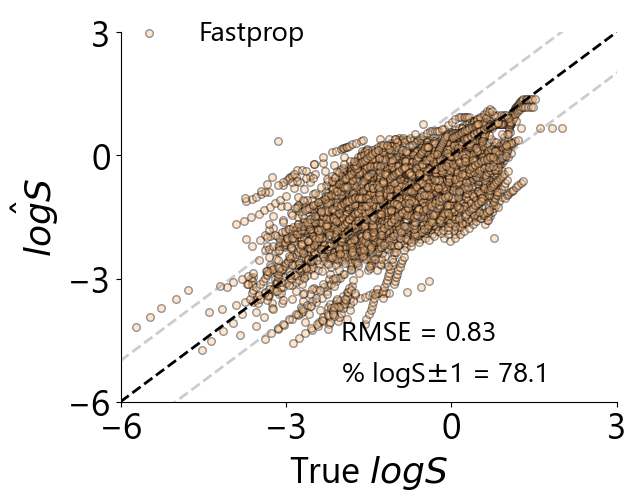

In [7]:
_src_dir: str = os.path.join(r"C:\Users\ChemeGrad2021\Documents\highsol\results\output\aleatoric_1701", "fastprop_5215")
fastprop_solprop_predictions: pd.DataFrame = pd.read_csv(os.path.join(_src_dir, "solprop_fastprop_nonaq_predictions.csv"))
fastprop_solprop_predictions[['solvent smiles', 'solute smiles']] = fastprop_solprop_predictions['smiles'].str.split('.', n=1, expand=True)
fastprop_solprop_predictions
solute_smiles = fastprop_solprop_predictions.pop('solute smiles')  
solvent_smiles = fastprop_solprop_predictions.pop('solvent smiles')  

both = fastprop_solprop_predictions.pop('smiles')  

fastprop_solprop_predictions.insert(0, 'solvent smiles', solvent_smiles) 
fastprop_solprop_predictions.insert(0, 'solute smiles', solute_smiles) 

mse_fastprop_solprop, percentage_within_1_unit_fastprop_solprop = stats(fastprop_solprop_predictions['logS_true'], fastprop_solprop_predictions['logS_pred'])
solprop_parity_plot(fastprop_solprop_predictions['logS_true'],
            fastprop_solprop_predictions['logS_pred'],
            'Fastprop', 
            [colors[2]],
            mse_fastprop_solprop, 
            percentage_within_1_unit_fastprop_solprop)

In [8]:
from scipy.stats import pearsonr
print(pearsonr(fastprop_solprop_predictions['logS_true'],
            fastprop_solprop_predictions['logS_pred']))

PearsonRResult(statistic=0.660850616042986, pvalue=0.0)


chemprop performance on Leeds

In [9]:
_src_dir: str = os.path.join(r"C:\Users\ChemeGrad2021\Documents\highsol\results\chemprop_output\aleatoric_1701", "chemprop_5215")
leeds_acetone_chemprop: pd.DataFrame = pd.read_csv(os.path.join(_src_dir, "leeds_acetone_chemprop_predictions.csv"))
leeds_acetone_chemprop['logS_true'] = leeds_acetone['logS_true']
leeds_benzene_chemprop: pd.DataFrame = pd.read_csv(os.path.join(_src_dir, "leeds_benzene_chemprop_predictions.csv"))
leeds_benzene_chemprop['logS_true'] = leeds_benzene['logS_true']
leeds_ethanol_chemprop: pd.DataFrame = pd.read_csv(os.path.join(_src_dir, "leeds_ethanol_chemprop_predictions.csv"))
leeds_ethanol_chemprop['logS_true'] = leeds_ethanol['logS_true']

leeds_all_chemprop = pd.concat([leeds_acetone_chemprop, leeds_benzene_chemprop, leeds_ethanol_chemprop], ignore_index=True, axis=0) 

In [10]:
mse_leeds_chemprop, percentage_within_1_unit_leeds_chemprop = stats(leeds_all_chemprop['logS_true'], leeds_all_chemprop['logS_pred'])
print("MSE chemprop= " + f"{np.sqrt(mse_leeds_chemprop)}", "\nPercentage within 1 logS for Fastprop-sobolev = " + f"{percentage_within_1_unit_leeds_chemprop}")

MSE chemprop= 0.9868974628737778 
Percentage within 1 logS for Fastprop-sobolev = 70.9104938271605


<AxesSubplot: xlabel='True $logS$', ylabel='$\\hat{logS}$'>

<Figure size 640x480 with 0 Axes>

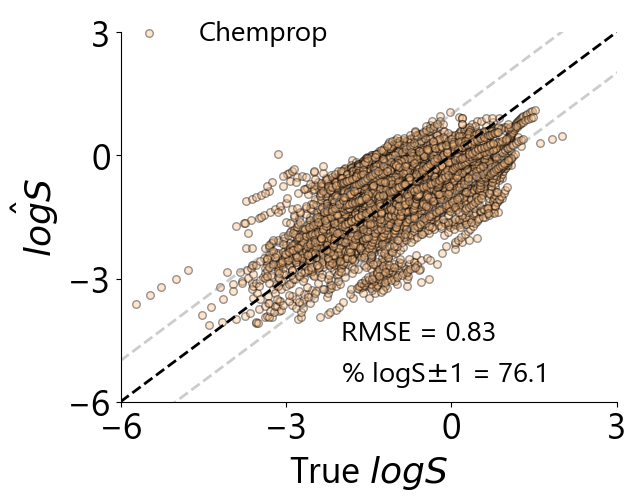

In [11]:
_src_dir: str = os.path.join(r"C:\Users\ChemeGrad2021\Documents\highsol\results\chemprop_output\aleatoric_1701", "chemprop_5215")
chemprop_solprop_predictions: pd.DataFrame = pd.read_csv(os.path.join(_src_dir, "solprop_chemprop_nonaq_predictions.csv"))

mse_chemprop_solprop, percentage_within_1_unit_chemprop_solprop = stats(chemprop_solprop_predictions['logS_true'], chemprop_solprop_predictions['logS_pred'])
solprop_parity_plot(chemprop_solprop_predictions['logS_true'],
            chemprop_solprop_predictions['logS_pred'],
            'Chemprop', 
            [colors[2]],
            mse_chemprop_solprop, 
            percentage_within_1_unit_chemprop_solprop)

In [12]:
from scipy.stats import pearsonr
print(pearsonr(chemprop_solprop_predictions['logS_true'],
            chemprop_solprop_predictions['logS_pred']))

PearsonRResult(statistic=0.6541724554081934, pvalue=0.0)


Solprop performance on Leeds

In [9]:
_src_dir: str = os.path.join(r"C:\Users\ChemeGrad2021\Documents\highsol\final_results", "solprop_predictions")
leeds_acetone_solprop: pd.DataFrame = pd.read_csv(os.path.join(_src_dir, "leeds_acetone_vermeire_predictions.csv"))
leeds_acetone_solprop['logS_true'] = leeds_acetone['logS_true']
leeds_benzene_solprop: pd.DataFrame = pd.read_csv(os.path.join(_src_dir, "leeds_benzene_vermeire_predictions.csv"))
leeds_benzene_solprop['logS_true'] = leeds_benzene['logS_true']
leeds_ethanol_solprop: pd.DataFrame = pd.read_csv(os.path.join(_src_dir, "leeds_ethanol_vermeire_predictions.csv"))
leeds_ethanol_solprop['logS_true'] = leeds_ethanol['logS_true']

leeds_all_solprop = pd.concat([leeds_acetone_solprop, leeds_benzene_solprop, leeds_ethanol_solprop], ignore_index=True, axis=0) 

In [10]:
mse_leeds_solprop, percentage_within_1_unit_leeds_solprop = stats(leeds_all_solprop['logS_true'], leeds_all_solprop['logST (method1) [log10(mol/L)]'])
print("MSE Solprop= " + f"{np.sqrt(mse_leeds_solprop)}", "\nPercentage within 1 logS for Solprop = " + f"{percentage_within_1_unit_leeds_solprop}")

MSE Solprop= 2.157430388600152 
Percentage within 1 logS for Solprop = 41.24031007751938


<AxesSubplot: xlabel='True $logS$', ylabel='$\\hat{logS}$'>

<Figure size 640x480 with 0 Axes>

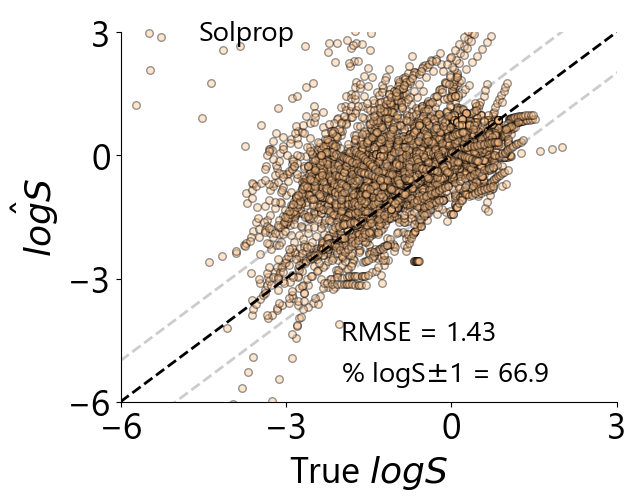

In [11]:
_src_dir: str = os.path.join(r"C:\Users\ChemeGrad2021\Documents\highsol\final_results", "solprop_predictions")
vermiere_solprop_predictions: pd.DataFrame = pd.read_csv(os.path.join(_src_dir, "solprop_nonaq_vermeire_predictions.csv"))
vermiere_solprop_predictions = vermiere_solprop_predictions.rename(columns = {"Solvent": "solvent smiles","Solute": "solute smiles", "Temp" : "temperature"})
solprop_solprop_predictions = fastprop_solprop_predictions.merge(vermiere_solprop_predictions[['solute smiles', 'solvent smiles', 'temperature', 'logST (method1) [log10(mol/L)]']], 
                on=['solute smiles', 'solvent smiles', 'temperature'], 
                how='left')
solprop_solprop_predictions.pop('logS_pred')
solprop_solprop_predictions.rename(columns = {'logST (method1) [log10(mol/L)]': 'logS_pred'}, inplace=True)

mse_solprop_solprop, percentage_within_1_unit_solprop_solprop = stats(solprop_solprop_predictions['logS_true'], solprop_solprop_predictions['logS_pred'])
solprop_parity_plot(solprop_solprop_predictions['logS_true'],
            solprop_solprop_predictions['logS_pred'],
            'Solprop', 
            [colors[2]],
            mse_solprop_solprop, 
            percentage_within_1_unit_solprop_solprop)

Plotting all together for Figure 2

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


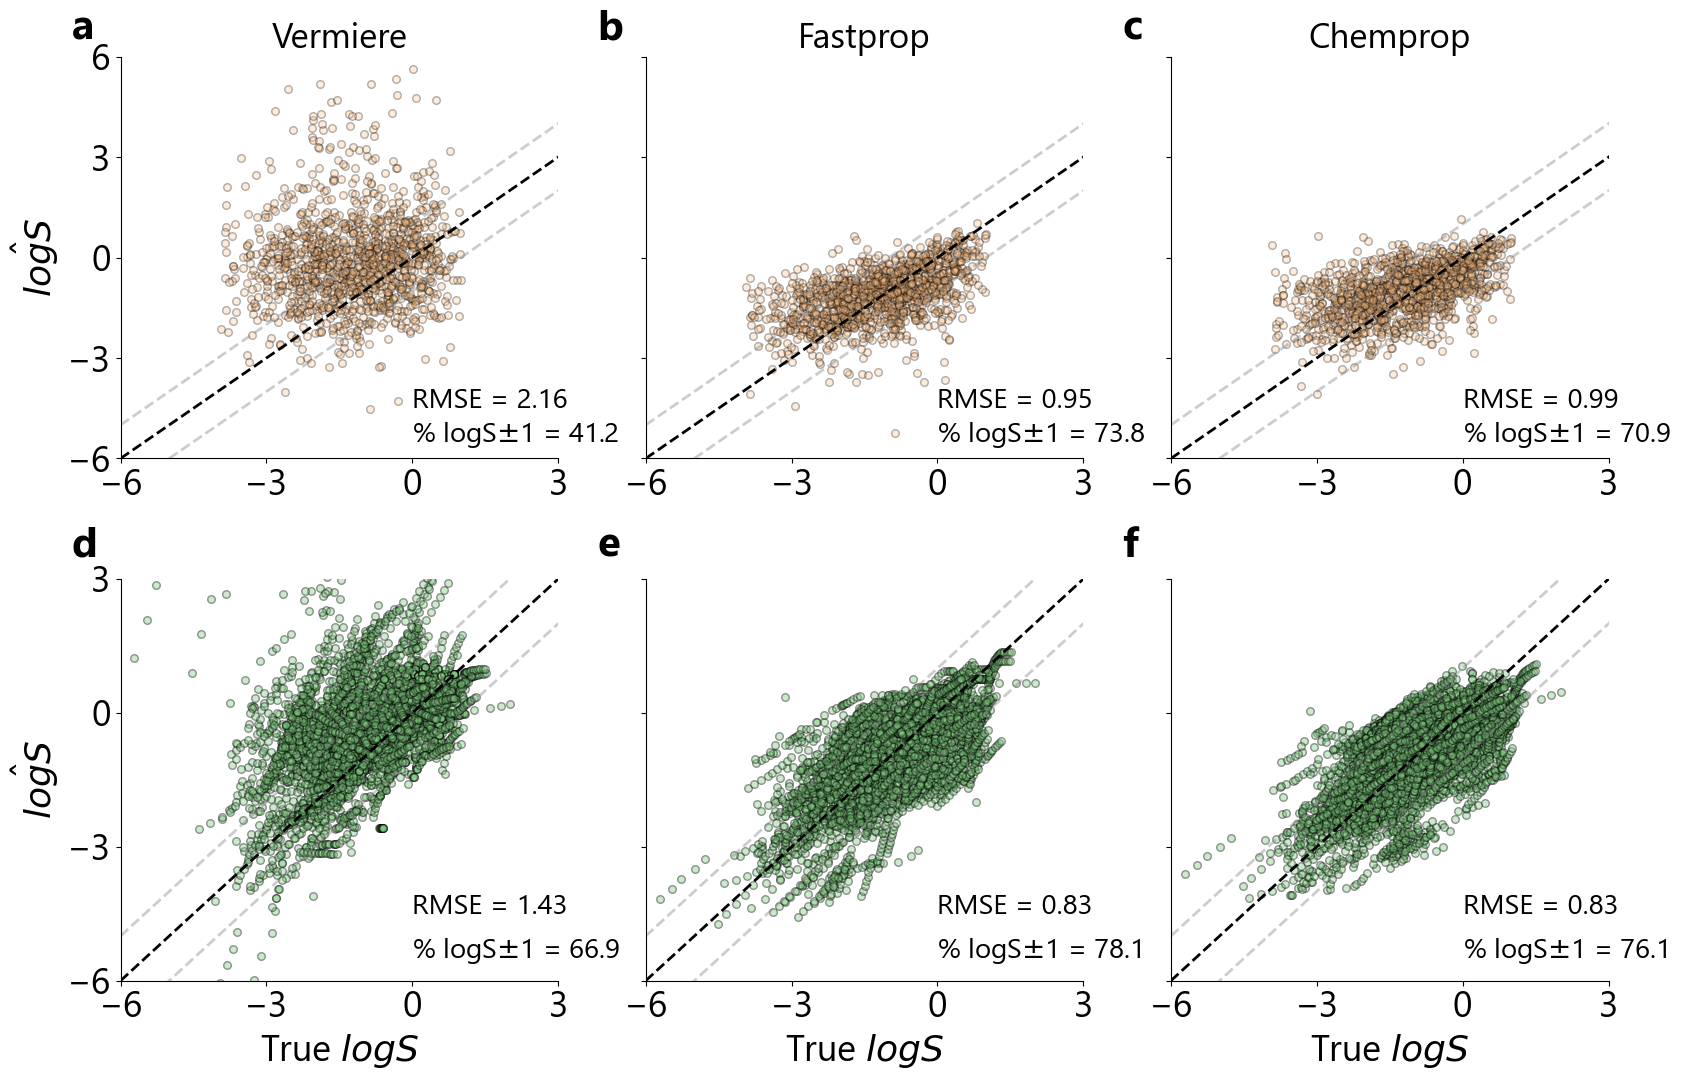

In [12]:
plt.figure(figsize=[6.4*3,4.8*2.5])
ax1 = plt.subplot2grid(shape=(2,3), loc=(0,0), colspan=1)

ax1.plot([-6, 6], [-6,6], linestyle = '--', linewidth = 2, color = 'black')
ax1.plot([-6, 6], [-5,7], linestyle = '--', linewidth = 2, color = 'gray', alpha = 0.4)
ax1.plot([-6, 6], [-7,5], linestyle = '--', linewidth = 2, color = 'gray', alpha = 0.4)

ax1.scatter(leeds_all_solprop['logS_true'],leeds_all_solprop['logST (method1) [log10(mol/L)]'], alpha =0.3, s = 30, edgecolors = 'black', color = colors[2])


ax1.set_xlim([-6, 3])
ax1.set_xticks([-6, -3, 0, 3])
ax1.set_ylim([-6,6])
ax1.set_yticks([-6, -3, 0, 3, 6])

ax1.set_ylabel(r"$\hat{logS}$")
#ax1.set_xlabel(r"True $logS$")
ax1.legend(prop={'size': 20}, loc = 'upper right', frameon = False, bbox_to_anchor=(1.1,0.6)) 
ax1.spines[['right', 'top']].set_visible(False)
ax1.set_title("Vermiere", fontsize = 25)
ax1.text(-0,-4.5, f"RMSE = {np.sqrt(mse_leeds_solprop):.2f}", fontsize = 20)
ax1.text(-0,-5.5, '% logS' + r'$\pm$'  + f"1 = {percentage_within_1_unit_leeds_solprop:.1f}", fontsize = 20)
ax1.text(-7, 6.5, "a", weight='bold', fontsize = 30)


ax2 = plt.subplot2grid(shape=(2,3), loc=(0,1), colspan=1)

ax2.plot([-6, 6], [-6,6], linestyle = '--', linewidth = 2, color = 'black')
ax2.plot([-6, 6], [-5,7], linestyle = '--', linewidth = 2, color = 'gray', alpha = 0.4)
ax2.plot([-6, 6], [-7,5], linestyle = '--', linewidth = 2, color = 'gray', alpha = 0.4)

ax2.scatter(leeds_all['logS_true'],leeds_all['logS_pred'], alpha =0.3, s = 30, edgecolors = 'black', color = colors[2])

ax2.set_xlim([-6, 3])
ax2.set_xticks([-6, -3, 0, 3])
ax2.set_ylim([-6,6])
ax2.set_yticks([-6, -3, 0, 3, 6])
ax2.set_yticklabels([])

#ax2.set_ylabel(r"$\hat{logS}$")
#ax2.set_xlabel(r"True $logS$")
ax2.legend(prop={'size': 20}, loc = 'upper right', frameon = False, bbox_to_anchor=(1.1,0.6)) 
ax2.spines[['right', 'top']].set_visible(False)
ax2.text(-0,-4.5, f"RMSE = {np.sqrt(mse_leeds_fastprop):.2f}", fontsize = 20)
ax2.text(-0,-5.5, '% logS' + r'$\pm$'  + f"1 = {percentage_within_1_unit_leeds_fastprop:.1f}", fontsize = 20)
ax2.text(-7, 6.5, "b", weight='bold', fontsize = 30)

ax2.set_title("Fastprop", fontsize = 25)

ax3 = plt.subplot2grid(shape=(2,3), loc=(0,2), colspan=1)

ax3.plot([-6, 6], [-6,6], linestyle = '--', linewidth = 2, color = 'black')
ax3.plot([-6, 6], [-5,7], linestyle = '--', linewidth = 2, color = 'gray', alpha = 0.4)
ax3.plot([-6, 6], [-7,5], linestyle = '--', linewidth = 2, color = 'gray', alpha = 0.4)

ax3.scatter(leeds_all_chemprop['logS_true'],leeds_all_chemprop['logS_pred'], alpha =0.3, s = 30, edgecolors = 'black', color = colors[2])

ax3.set_xlim([-6, 3])
ax3.set_xticks([-6, -3, 0, 3])

ax3.set_ylim([-6,6])
ax3.set_yticks([-6, -3, 0, 3, 6])
ax3.set_yticklabels([])

#ax3.set_ylabel(r"$\hat{logS}$")
#ax3.set_xlabel(r"True $logS$")
ax3.legend(prop={'size': 20}, loc = 'upper right', frameon = False, bbox_to_anchor=(1.08,0.3)) 
ax3.text(-0,-4.5, f"RMSE = {np.sqrt(mse_leeds_chemprop):.2f}", fontsize = 20)
ax3.text(-0,-5.5, '% logS' + r'$\pm$'  + f"1 = {percentage_within_1_unit_leeds_chemprop:.1f}", fontsize = 20)
ax3.text(-7, 6.5, "c", weight='bold', fontsize = 30)

#ax3.text(1,-5.5, "RMSE = 2.01", fontsize = 20)
ax3.spines[['right', 'top']].set_visible(False)
ax3.set_title("Chemprop", fontsize = 25)

ax4 = plt.subplot2grid(shape=(2,3), loc=(1,0), colspan=1)
ax4.plot([-6, 6], [-6,6], linestyle = '--', linewidth = 2, color = 'black')
ax4.plot([-6, 6], [-7,5], linestyle = '--', linewidth = 2, color = 'gray', alpha = 0.4)
ax4.plot([-6, 6], [-5,7], linestyle = '--', linewidth = 2, color = 'gray', alpha = 0.4)
ax4.scatter(solprop_solprop_predictions['logS_true'],solprop_solprop_predictions['logS_pred'], alpha =0.4, s = 30, edgecolors = 'black', color = colors[0])
ax4.set_xlim([-6,3])
ax4.set_xticks([-6, -3, 0, 3])
ax4.set_ylim([-6,3])
ax4.set_yticks([-6, -3, 0, 3])
ax4.set_ylabel(r"$\hat{logS}$")
ax4.set_xlabel(r"True $logS$")
#ax4.legend(prop={'size': 20}, loc = 'upper left', frameon = False, bbox_to_anchor=(-0.05,1.1)) 
ax4.text(0,-4.5, f"RMSE = {np.sqrt(mse_solprop_solprop):.2f}", fontsize = 20)
ax4.text(0,-5.5, '% logS' + r'$\pm$'  + f"1 = {percentage_within_1_unit_solprop_solprop:.1f}", fontsize = 20)
ax4.spines[['right', 'top']].set_visible(False)
ax4.text(-7, 3.5, "d", weight='bold', fontsize = 30)


ax5 = plt.subplot2grid(shape=(2,3), loc=(1,1), colspan=1)
ax5.plot([-6, 6], [-6,6], linestyle = '--', linewidth = 2, color = 'black')
ax5.plot([-6, 6], [-7,5], linestyle = '--', linewidth = 2, color = 'gray', alpha = 0.4)
ax5.plot([-6, 6], [-5,7], linestyle = '--', linewidth = 2, color = 'gray', alpha = 0.4)
ax5.scatter(fastprop_solprop_predictions['logS_true'],fastprop_solprop_predictions['logS_pred'], alpha =0.4, s = 30, edgecolors = 'black', color = colors[0])
ax5.set_xlim([-6,3])
ax5.set_xticks([-6, -3, 0, 3])
ax5.set_ylim([-6,3])
ax5.set_yticks([-6, -3, 0, 3])
ax5.set_yticklabels([])
#ax5.set_ylabel(r"$\hat{logS}$")
ax5.set_xlabel(r"True $logS$")
#ax5.legend(prop={'size': 20}, loc = 'upper left', frameon = False, bbox_to_anchor=(-0.05,1.1)) 
ax5.text(0,-4.5, f"RMSE = {np.sqrt(mse_fastprop_solprop):.2f}", fontsize = 20)
ax5.text(0,-5.5, '% logS' + r'$\pm$'  + f"1 = {percentage_within_1_unit_fastprop_solprop:.1f}", fontsize = 20)
ax5.spines[['right', 'top']].set_visible(False)
ax5.text(-7, 3.5, "e", weight='bold', fontsize = 30)


ax6 = plt.subplot2grid(shape=(2,3), loc=(1,2), colspan=1)
ax6.plot([-6, 6], [-6,6], linestyle = '--', linewidth = 2, color = 'black')
ax6.plot([-6, 6], [-7,5], linestyle = '--', linewidth = 2, color = 'gray', alpha = 0.4)
ax6.plot([-6, 6], [-5,7], linestyle = '--', linewidth = 2, color = 'gray', alpha = 0.4)
ax6.scatter(chemprop_solprop_predictions['logS_true'],chemprop_solprop_predictions['logS_pred'], alpha =0.4, s = 30, edgecolors = 'black', color = colors[0])
ax6.set_xlim([-6,3])
ax6.set_xticks([-6, -3, 0, 3])
ax6.set_ylim([-6,3])
ax6.set_yticks([-6, -3, 0, 3])
ax6.set_yticklabels([])
#ax5.set_ylabel(r"$\hat{logS}$")
ax6.set_xlabel(r"True $logS$")
#ax5.legend(prop={'size': 20}, loc = 'upper left', frameon = False, bbox_to_anchor=(-0.05,1.1)) 
ax6.text(0,-4.5, f"RMSE = {np.sqrt(mse_chemprop_solprop):.2f}", fontsize = 20)
ax6.text(0,-5.5, '% logS' + r'$\pm$'  + f"1 = {percentage_within_1_unit_chemprop_solprop:.1f}", fontsize = 20)
ax6.spines[['right', 'top']].set_visible(False)
ax6.text(-7, 3.5, "f", weight='bold', fontsize = 30)

plt.subplots_adjust(hspace=0.3)
plt.show()
